In [1]:
# ============================================
#  Ensemble Learning: Voting Classifier (Soft)
# ============================================

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report,
    roc_curve, auc
)
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load preprocessed dataset
df = pd.read_csv("/content/drive/MyDrive/data/preprocessed_ids2018_subset_after_research.csv")
print("Loaded dataset:", df.shape)

# Use 30% subset (same as we did for baseline)
df = df.sample(frac=0.2, random_state=42)
print("Subset shape:", df.shape)

# Split features and labels
X = df.drop(columns=['Label'])
y = df['Label']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape)


Mounted at /content/drive
Loaded dataset: (2098077, 35)
Subset shape: (419615, 35)
Train: (335692, 34) Test: (83923, 34)


In [2]:

# ==========================
#  Define Base Models
# ==========================

rf = RandomForestClassifier(
    n_estimators=100, max_depth=20, min_samples_split=5,
    random_state=42, n_jobs=-1
)

lr = LogisticRegression(max_iter=500, random_state=42)

dt = DecisionTreeClassifier(max_depth=20, random_state=42)


# # Use smaller sample for SVM to reduce training time
# svm_frac = 0.05  # 5% of training data
# svm_X_train = X_train.sample(frac=svm_frac, random_state=42)
# svm_y_train = y_train.loc[svm_X_train.index]

svm = SVC(probability=True, kernel='rbf', random_state=42)





In [3]:
import joblib

# ==========================
#  Train Base Models
# ==========================
print("\nTraining base models...")
total_start = time.time()

# Random Forest
start = time.time()
rf.fit(X_train, y_train)
print("Random Forest trained in {:.2f} seconds".format(time.time() - start))

# Logistic Regression
start = time.time()
lr.fit(X_train, y_train)
print("Logistic Regression trained in {:.2f} seconds".format(time.time() - start))

# Decision Tree
start = time.time()
dt.fit(X_train, y_train)
print("Decision Tree trained in {:.2f} seconds".format(time.time() - start))

# SVM
start = time.time()
svm.fit(X_train, y_train)
print("SVM trained in {:.2f} seconds".format(time.time() - start))

print("\nAll base models trained in {:.2f} minutes".format((time.time() - total_start) / 60))


# ==========================
#  Build Soft Voting Ensemble
# ==========================
ensemble = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('lr', lr),
        ('svm', svm),
        ('dt', dt)
    ],
    voting='soft',
    weights=[3, 1, 1, 1]  # RF votes 3x more than others

)

# Each classifier uses different learning mechanisms:
# RandomForest → Bagging-based ensemble of trees.
# LogisticRegression → Linear model, good at separating classes with linear boundaries.
# SVM → Finds optimal hyperplane using support vectors; probability=True is required for soft voting.
# DecisionTree → Simple non-linear model.


# Use already fitted models to avoid retraining
ensemble.estimators_ = [rf, lr, svm, dt]
ensemble.classes_ = np.unique(y_train)

print("\nSoft Voting Ensemble ready (no retraining needed).")

# Save Ensemble Model
joblib.dump(ensemble, "/content/drive/MyDrive/models/ensemble_voting_model_all_attacks_after_research-20%subset.pkl")
print("Model saved to Drive: ensemble_voting_model_XSS_SQLi_DDoS_Dataset-Subset-20%.pkl")


# print("\nTraining VotingClassifier (soft voting)...")
# start = time.time()
# ensemble.fit(X_train, y_train)
# print("Ensemble trained in {:.2f} minutes".format((time.time() - start) / 60))



Training base models...
Random Forest trained in 61.49 seconds
Logistic Regression trained in 8.08 seconds
Decision Tree trained in 5.80 seconds
SVM trained in 3090.51 seconds

All base models trained in 52.76 minutes

Soft Voting Ensemble ready (no retraining needed).
Model saved to Drive: ensemble_voting_model_XSS_SQLi_DDoS_Dataset-Subset-50%.pkl



Accuracy: 0.9998093490461495
Precision: 0.9999436603847995
Recall: 0.9996057559629411
F1 Score: 0.9997746796225884
ROC-AUC: 0.9999956839349822

Confusion Matrix:
 [[48410     2]
 [   14 35497]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     48412
           1       1.00      1.00      1.00     35511

    accuracy                           1.00     83923
   macro avg       1.00      1.00      1.00     83923
weighted avg       1.00      1.00      1.00     83923



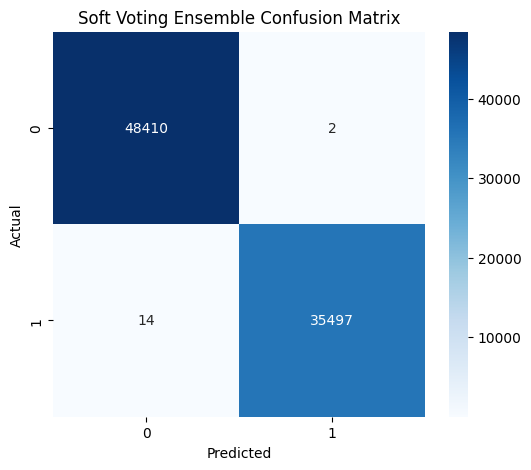

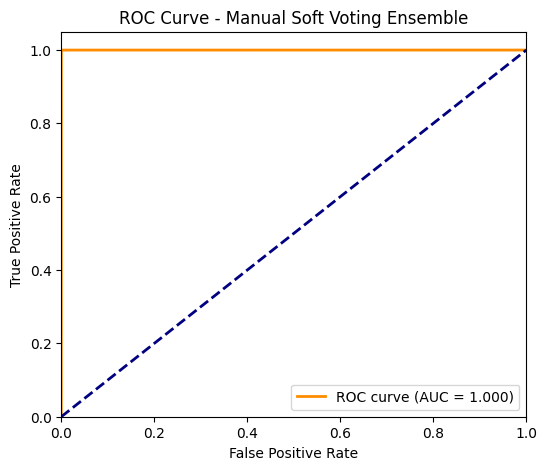

In [4]:
# ==========================
#  Manual Soft Voting
# ==========================
import numpy as np

# Collect probabilities from each base model
rf_probs = rf.predict_proba(X_test)[:, 1]
lr_probs = lr.predict_proba(X_test)[:, 1]
svm_probs = svm.predict_proba(X_test)[:, 1]
dt_probs = dt.predict_proba(X_test)[:, 1]

# Average probabilities (soft voting)
avg_probs = (rf_probs + lr_probs + svm_probs + dt_probs) / 4
avg_preds = (avg_probs >= 0.5).astype(int)

# Evaluate
print("\nAccuracy:", accuracy_score(y_test, avg_preds))
print("Precision:", precision_score(y_test, avg_preds))
print("Recall:", recall_score(y_test, avg_preds))
print("F1 Score:", f1_score(y_test, avg_preds))
print("ROC-AUC:", roc_auc_score(y_test, avg_probs))

# Confusion Matrix
cm = confusion_matrix(y_test, avg_preds)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, avg_preds))

# Heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Soft Voting Ensemble Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, avg_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.3f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Manual Soft Voting Ensemble')
plt.legend(loc="lower right")
plt.show()
